In [1]:
import pymc as pm
import jax.numpy as jnp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpyro
numpyro.set_platform("cpu")
numpyro.set_host_device_count(16)

In [402]:
coords = {
    "time": np.arange(0, 156),
    "channels": ["ch1", "ch2", "ch3"]
}

with pm.Model(coords=coords) as gen_model:
    # Data
    imp_mu = pm.LogNormal("imp_mu", 0, 2, dims="channels")
    imp_alpha = pm.LogNormal("imp_alpha", 0, 2, dims="channels")
    imp_p = pm.Beta("imp_p", alpha=2, beta=2, dims="channels")
    imp = pm.ZeroInflatedNegativeBinomial("imp", mu=imp_mu, alpha=imp_alpha, psi=imp_p, dims=("time", "channels"))
    
    trend_mu = pm.Normal("trend_mu", 0, .1)
    trend_sigma = pm.HalfNormal("trend_sigma", 1)
    trend = pm.GaussianRandomWalk("trend", mu=trend_mu, sigma=trend_sigma, init_dist=pm.DiracDelta.dist(0), dims="time")   
    

    # Priors
    
    coeff = pm.LogNormal("b", mu=-2, sigma=1, dims="channels")
    ec_m = pm.LogNormal("ec_m", mu=np.log(1.2), sigma=.5, dims="channels")
    slope_m = pm.LogNormal("slope_m_", mu=np.log(.2), sigma=.5, dims="channels")
    adjusted_slope = pm.Deterministic("slope_m", slope_m + .8, dims="channels")
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    
    weighted_imp = imp/imp_mu[None, :]
    
    hill_K = weighted_imp**(adjusted_slope[None, :])
    hill_c = (ec_m**adjusted_slope)[None, :]
    hill = hill_K/(hill_K + hill_c)
    
    sigma = pm.HalfNormal("sigma", 1)
    media_contributions = pm.Deterministic("media_contributions", hill * coeff, dims=("time", "channels"))
    base = pm.Deterministic("base", trend + intercept, dims="time")
    mu = pm.Deterministic("mu", media_contributions.sum(axis=1) + base, dims="time")
    
    obs = pm.Normal("obs", mu=mu, sigma=sigma, dims="time")

    

In [461]:
N_samples = 156
time_values = pd.date_range(start="2020-01-01", periods=N_samples, freq="W-MON")
with pm.do(gen_model, {"imp_mu": [10, 20, 50], "b": [3, 6, 8],"ec_m": [1, 1.2, 4], "slope_m_": [.6, .2, 1.2], "trend_mu": 0.01, "trend_sigma": 0.1, "intercept": 3, 'sigma': 1}) as sample_model:
  sample_model.set_dim('time', N_samples, time_values)
  trace_sample = pm.sample_prior_predictive()

Sampling: [imp, imp_alpha, imp_p, obs, trend]


In [462]:
sample_y = trace_sample.prior["obs"][0, 3, :]
sample_impressions = trace_sample.prior["imp"][0, 3,:, :]
sample_trend = trace_sample.prior["trend"][0, 3, :]
sample_contributions = trace_sample.prior["media_contributions"][0, 3, :]
sample_slope = trace_sample.prior["slope_m"][0, 3, :]
sample_ec = [1, 1.2, 4]
sample_base = trace_sample.prior["base"][0, 3, :]

In [463]:
sample_contributions.sum()/sample_y.sum()

<xarray.DataArray ()> Size: 8B
array(0.50138475)
Coordinates:
    chain    int64 8B 0
    draw     int64 8B 3

In [464]:
sample_slope

<xarray.DataArray 'slope_m' (channels: 3)> Size: 24B
array([1.4, 1. , 2. ])
Coordinates:
    chain     int64 8B 0
    draw      int64 8B 3
  * channels  (channels) <U3 36B 'ch1' 'ch2' 'ch3'

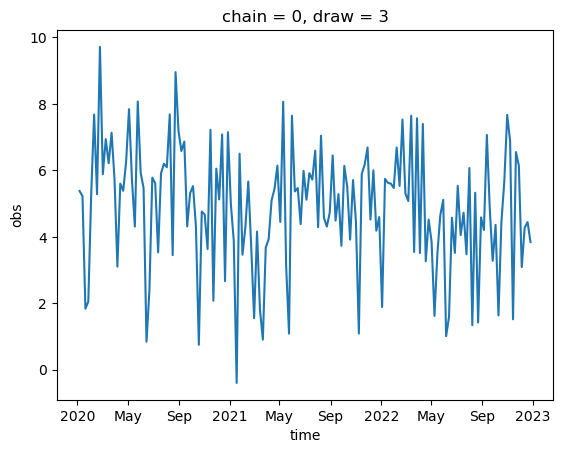

In [465]:
sample_y.plot.line(x='time')

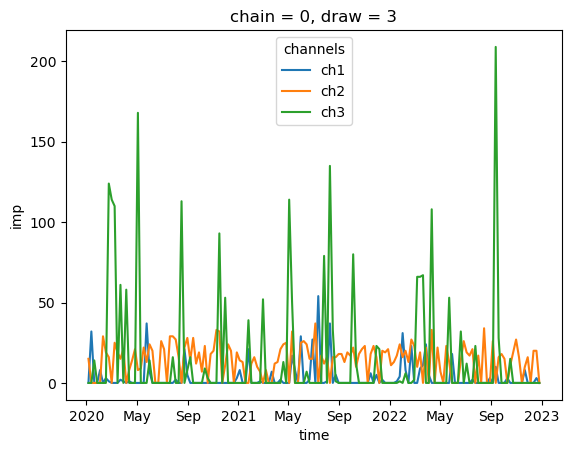

In [466]:
sample_impressions.T.plot.line(x='time')

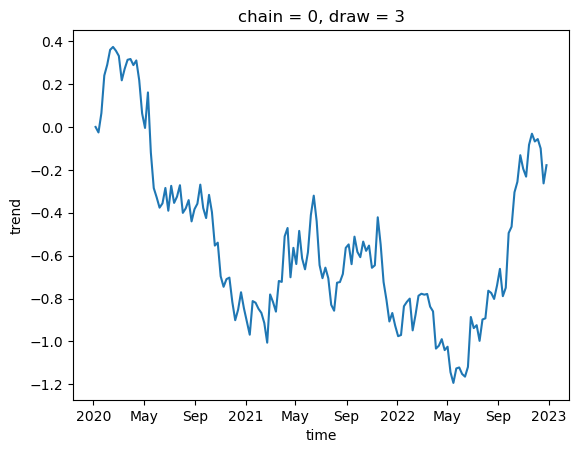

In [467]:
sample_trend.plot()

In [468]:
sample_impressions.shape

(156, 3)

In [469]:
with pm.observe(pm.do(gen_model, dict(trend=sample_trend, imp=sample_impressions)), dict(obs=sample_y, imp_mu=sample_impressions.where(lambda x: x>0).mean(dim='time'))) as obs_model:
    obs_model.set_dim('time', N_samples, time_values)
    prior = pm.sample_prior_predictive()
    trace = pm.sample(init='map', nuts_sampler='numpyro')

Sampling: [b, ec_m, imp_alpha, imp_mu, imp_p, intercept, obs, sigma, slope_m_, trend_mu, trend_sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [470]:
pm.summary(trace, var_names=['b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[ch1],3.645,0.733,2.321,4.945,0.013,0.009,3777.0,2701.0,1.0
b[ch2],4.497,0.591,3.430,5.625,0.011,0.008,3024.0,2568.0,1.0
b[ch3],3.149,0.817,1.861,4.777,0.014,0.010,3394.0,2552.0,1.0


array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'ec_m'}>,
        <Axes: title={'center': 'ec_m'}>],
       [<Axes: title={'center': 'slope_m'}>,
        <Axes: title={'center': 'slope_m'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

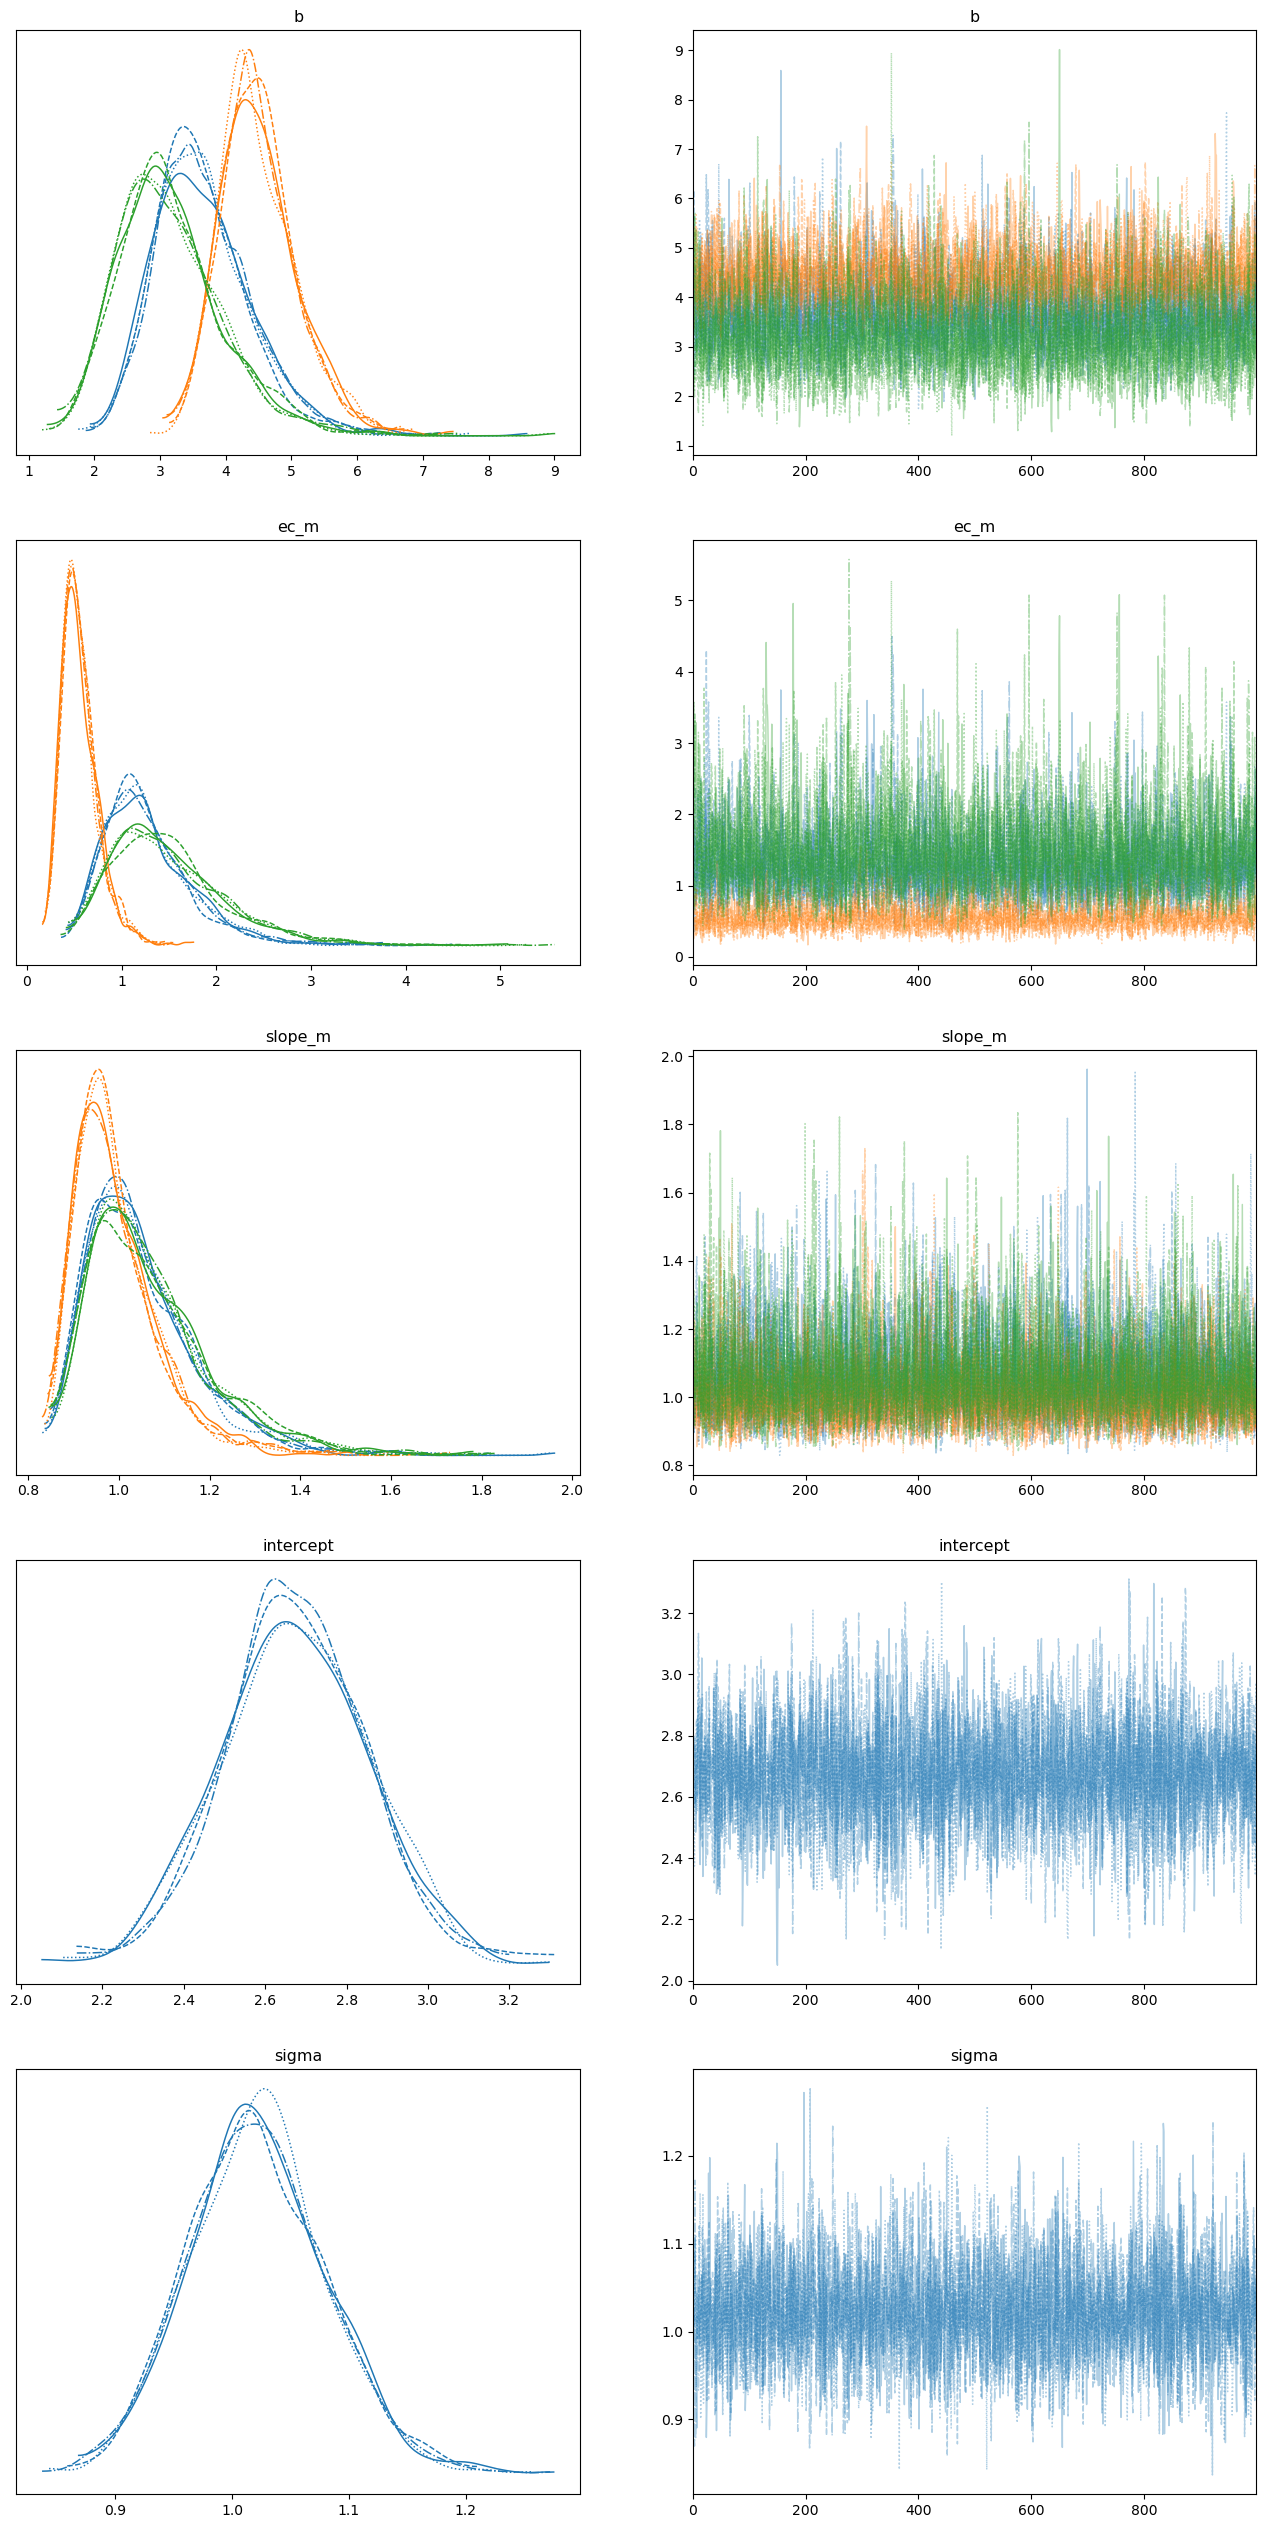

In [471]:
pm.plot_trace(trace, var_names=['b', 'ec_m', 'slope_m', 'intercept', 'sigma'], figsize=(16, 32))

In [472]:
trace.posterior = (trace
  .posterior
  .assign(
    yearly_contributions=xr.concat(
      [(trace
        .posterior["media_contributions"]
        .where(lambda x: x.time.dt.year == year)
        .sum(dim="time"))
       for year in np.unique(
         trace
         .posterior["media_contributions"]
         .time
         .dt
         .year)], 
      dim='year'),
    yearly_base=xr.concat(
      [(trace
        .posterior["base"]
        .where(lambda x: x.time.dt.year == year)
        .sum(dim="time"))
       for year in np.unique(
         trace
         .posterior["base"]
         .time
         .dt
         .year)], dim='year'
    )
  )
)

In [473]:
trace.posterior = trace.posterior.assign_coords(year=np.unique(trace.posterior.time.dt.year))

In [474]:
yearly_impressions = xr.concat(
      [(sample_impressions
        .where(lambda x: x.time.dt.year == year)
        .sum(dim="time"))
       for year in np.unique(
         sample_impressions
         .time
         .dt
         .year)], dim='year'
    )

In [475]:
yearly_impressions

<xarray.DataArray 'imp' (year: 3, channels: 3)> Size: 72B
array([[123., 776., 974.],
       [232., 722., 659.],
       [163., 675., 688.]])
Coordinates:
    chain     int64 8B 0
    draw      int64 8B 3
  * channels  (channels) <U3 36B 'ch1' 'ch2' 'ch3'
Dimensions without coordinates: year

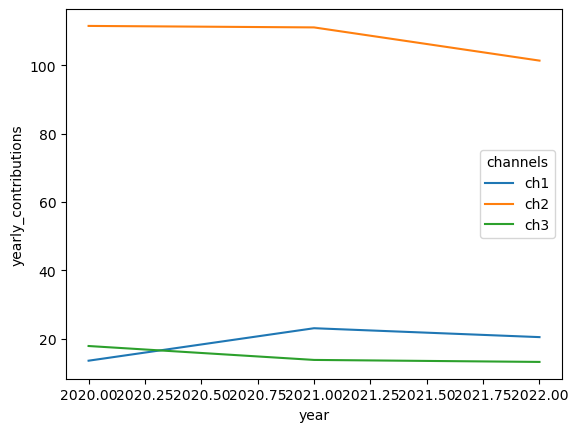

In [476]:
trace.posterior["yearly_contributions"].mean(dim=("draw", "chain")).plot.line(x='year')

In [477]:
import seaborn as sns

In [478]:
def area_chart(data: pd.DataFrame, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    data.plot.area(ax=ax, **kwargs)
    
    return ax

In [479]:
trace.posterior.media_contributions.mean(dim=("draw", "chain")).to_dataframe().reset_index()

,time,channels,media_contributions
0,2020-01-06,ch1,0.000000
1,2020-01-06,ch2,2.656552
2,2020-01-06,ch3,0.000000
3,2020-01-13,ch1,2.531686
4,2020-01-13,ch2,0.000000
...,...,...,...
463,2022-12-19,ch2,2.947640
464,2022-12-19,ch3,0.000000
465,2022-12-26,ch1,0.000000
466,2022-12-26,ch2,0.000000


In [480]:
base_contributions = trace.posterior.base.mean(dim=("draw", "chain")).to_dataframe().reset_index()
media_contributions = (
  trace
    .posterior
    .media_contributions
    .mean(dim=("draw", "chain"))
    .to_dataframe()
    .reset_index()
    .pivot(
      index='time', 
      columns='channels', 
      values='media_contributions'
      )
    .reset_index()
)
contributions = pd.merge(base_contributions, media_contributions, on='time')


<Axes: title={'center': 'Contributions'}, xlabel='Time', ylabel='Contributions'>

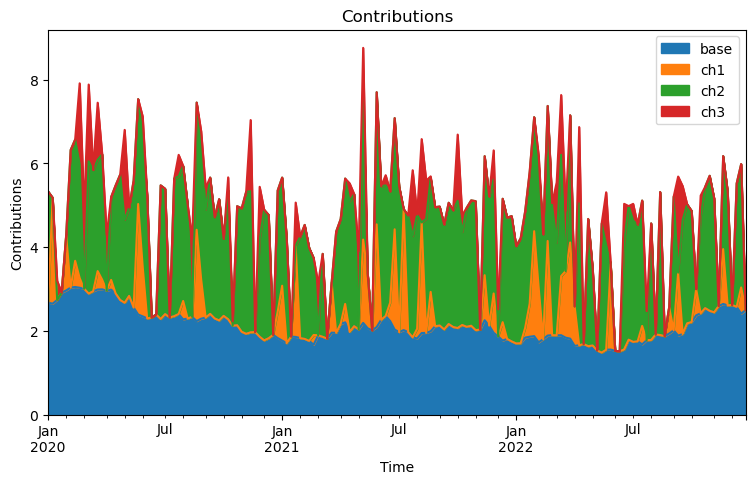

In [481]:
area_chart(contributions.set_index('time'), stacked=True, figsize=(9, 5), xlabel='Time', ylabel='Contributions', title="Contributions")

<Axes: xlabel='time', ylabel='media_contributions'>

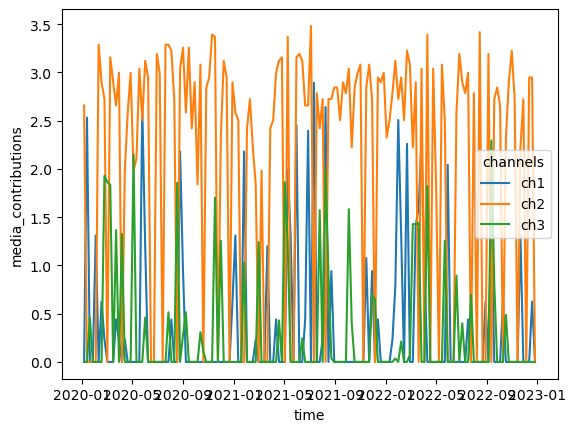

In [482]:
sns.lineplot(
  data=trace.posterior.media_contributions.mean(dim=("draw", "chain")).to_dataframe().reset_index(), 
  x='time', y='media_contributions', hue='channels')

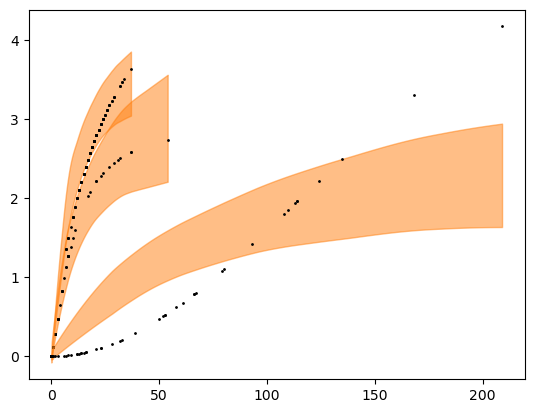

In [483]:
pm.plot_hdi(sample_impressions[:, 0], trace.posterior["media_contributions"][:, :, :, 0], hdi_prob=.9)
plt.scatter(sample_impressions[:, 0], sample_contributions[:, 0], color='k', s=1)
pm.plot_hdi(sample_impressions[:, 1], trace.posterior["media_contributions"][:, :, :, 1], hdi_prob=.9)
plt.scatter(sample_impressions[:, 1], sample_contributions[:, 1], color='k', s=1)
pm.plot_hdi(sample_impressions[:, 2], trace.posterior["media_contributions"][:, :, :, 2], hdi_prob=.9)
plt.scatter(sample_impressions[:, 2], sample_contributions[:, 2], color='k', s=1)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

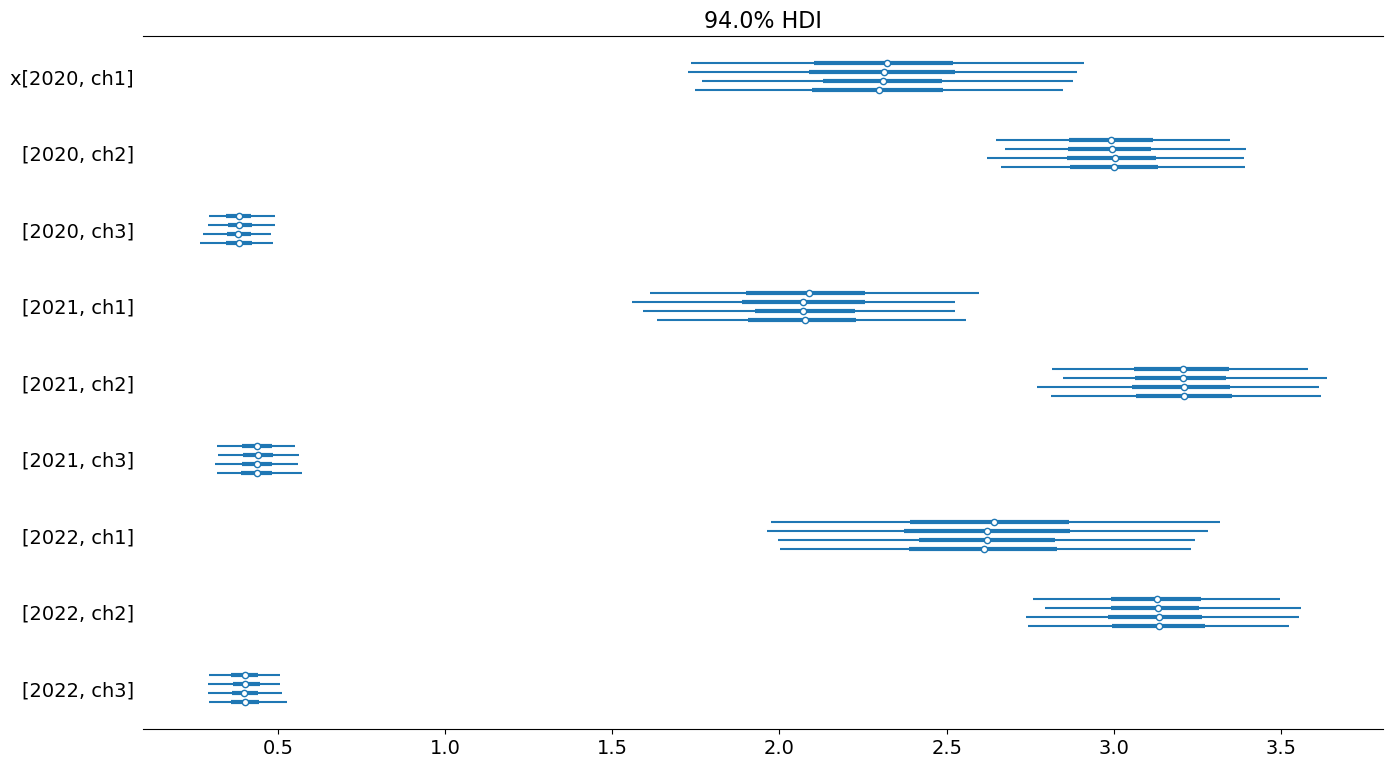

In [484]:
pm.plot_forest(trace.posterior["yearly_contributions"]/(48/1000*yearly_impressions),figsize=(16, 9))
#pm.plot_hdi(time_values, trace.posterior["base"], smooth=False, figsize=(16, 9))